In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

In [2]:
dataset = pd.read_csv('dataset_loker_downsynd.csv')

print("Dataset Overview:")
print(dataset.head())

Dataset Overview:
      Nama Pekerjaan                Perusahaan      Lokasi          Gaji  \
0      Asisten Dapur         PT Roti Nusantara     Jakarta  Rp 2.500.000   
1      Petugas Kebun        Taman Kota Mandiri     Bandung  Rp 2.000.000   
2  Operator Komputer           PT Digital Jaya    Surabaya  Rp 3.000.000   
3  Pembersih Ruangan       PT Bersih Sejahtera  Yogyakarta  Rp 2.200.000   
4  Fotografer Pemula  Studio Kreatif Nusantara    Denpasar  Rp 3.500.000   

                                 Deskripsi Pekerjaan       Kategori Minat  \
0  Membantu koki menyiapkan bahan masakan dan men...              Memasak   
1  Merawat tanaman, menyiram bunga, dan menjaga k...             Berkebun   
2  Mengoperasikan komputer untuk tugas-tugas sede...      Teknologi dasar   
3  Membersihkan ruangan kerja dan menjaga kebersi...  Lingkungan dan alam   
4  Mengambil foto sederhana dan membantu pengedit...      Fotografi, Seni   

                                Kemampuan Dibutuhkan  \
0  Men

In [3]:
dataset['Kategori Minat'] = dataset['Kategori Minat'].fillna('')
dataset['Kemampuan Dibutuhkan'] = dataset['Kemampuan Dibutuhkan'].fillna('')
dataset['Kondisi Kesehatan'] = dataset['Kondisi Kesehatan'].fillna('')

dataset['Kategori Minat'] = dataset['Kategori Minat'].str.split(', ')
dataset['Kemampuan Dibutuhkan'] = dataset['Kemampuan Dibutuhkan'].str.split(', ')
dataset['Kondisi Kesehatan'] = dataset['Kondisi Kesehatan'].str.split(', ')

In [4]:
minat_encoder = MultiLabelBinarizer()
skills_encoder = MultiLabelBinarizer()
kondisi_encoder = MultiLabelBinarizer()

minat_encoded = minat_encoder.fit_transform(dataset['Kategori Minat'])
skills_encoded = skills_encoder.fit_transform(dataset['Kemampuan Dibutuhkan'])
kondisi_encoded = kondisi_encoder.fit_transform(dataset['Kondisi Kesehatan'])

In [5]:
job_features = np.hstack([
    minat_encoded * 0.6,
    skills_encoded * 0.3,
    kondisi_encoded * 0.1
])

In [6]:
X_train, X_test = train_test_split(job_features, test_size=0.2, random_state=42)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')  # Output layer
])

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, X_train, epochs=1000, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.0078 - loss: 0.6901 - val_accuracy: 0.0000e+00 - val_loss: 0.6810
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0078 - loss: 0.6778 - val_accuracy: 0.0000e+00 - val_loss: 0.6649
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0035 - loss: 0.6603 - val_accuracy: 0.0000e+00 - val_loss: 0.6399
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0035 - loss: 0.6338 - val_accuracy: 0.0000e+00 - val_loss: 0.6023
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0035 - loss: 0.5968 - val_accuracy: 0.0000e+00 - val_loss: 0.5492
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0130 - loss: 0.5420 - val_accuracy: 0.0000e+00 - val_loss: 0.4790
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.4703 - val_accuracy: 0.0000e+00 - val_loss: 0.3965
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0000e+00 - lo

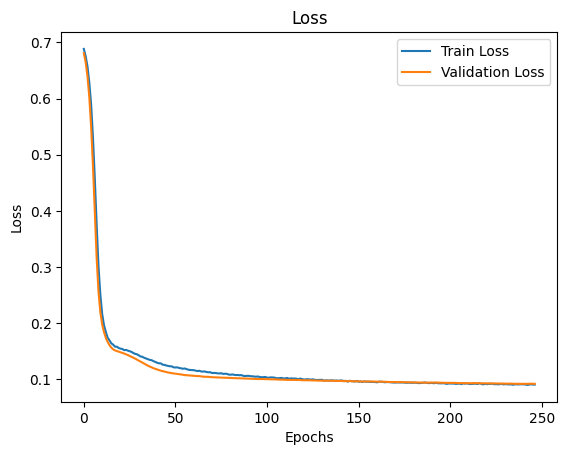

In [9]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
def rekomendasi_jobspark(minat_user, dataset, minat_encoder, skills_encoder, kondisi_encoder, model, kemampuan_user, kondisi_user, top_n=5):
    user_minat_vector = minat_encoder.transform([minat_user])

    user_skills_vector = np.zeros((user_minat_vector.shape[0], skills_encoded.shape[1]))
    user_conditions_vector = np.zeros((user_minat_vector.shape[0], kondisi_encoded.shape[1]))

    user_vector = np.hstack([
        user_minat_vector * 0.6,
        user_skills_vector * 0.3,
        user_conditions_vector * 0.1
    ])

    user_prediction = model.predict(user_vector.reshape(1, -1))

    nilai_similaritas = cosine_similarity(user_prediction, job_features)

    similiaritas_indeks = nilai_similaritas[0].argsort()[-top_n-1:-1][::-1]

    print("Top Recommendations:")
    for i in similiaritas_indeks:
        rekomendasi_jobspark = dataset.iloc[i]
        print(f"Nama Pekerjaan: {rekomendasi_jobspark['Nama Pekerjaan']}")
        print(f"Perusahaan: {rekomendasi_jobspark['Perusahaan']}")
        print(f"Lokasi: {rekomendasi_jobspark['Lokasi']}")
        print(f"Kualifikasi: {rekomendasi_jobspark['Kualifikasi']}")
        print(f"Minimal Pengalaman: {rekomendasi_jobspark['Minimal Pengalaman']}")
        print(f"Kategori Minat: {rekomendasi_jobspark['Kategori Minat']}")
        print(f"Kemampuan Dibutuhkan: {rekomendasi_jobspark['Kemampuan Dibutuhkan']}")
        print(f"Kondisi Kesehatan: {rekomendasi_jobspark['Kondisi Kesehatan']}")
        print("-" * 40)

In [21]:
kategori_minat = [
    "Seni", "Musik", "Menari", "Kerajinan tangan", "Berkebun",
    "Memasak", "Merawat hewan",
    "Teknologi dasar", "Fotografi", "Lingkungan dan alam"
]

kategori_kemampuan = [
    "Membaca dasar", "Menulis sederhana", "Mendengarkan instruksi",
    "Berbicara dengan orang lain", "Kerja tim", "Ketelitian",
    "Koordinasi tangan dan mata", "Kesabaran", "Kreativitas",
    "Mengikuti langkah-langkah sederhana", "Menggunakan alat sederhana",
    "Pemecahan masalah sederhana", "Mandiri dengan supervisi",
    "Menjaga kebersihan", "Mengatur waktu", "Ketahanan fisik ringan"
]

kategori_kesehatan = [
    "Menggunakan kursi roda", "Membutuhkan kacamata",
    "Menggunakan alat bantu dengar", "Kesulitan berdiri terlalu lama",
    "Tidak boleh mengangkat beban berat", "Membutuhkan lingkungan kerja tenang",
    "Tidak cocok di suhu panas", "Tidak cocok di suhu dingin",
    "Alergi bahan kimia tertentu", "Membutuhkan istirahat berkala"
]

minat_dropdown = widgets.Dropdown(
    options=kategori_minat,
    description='Minat:',
)

kemampuan_dropdown = widgets.Dropdown(
    options=kategori_kemampuan,
    description='Kemampuan:',
)

kondisi_dropdown = widgets.Dropdown(
    options=kategori_kesehatan,
    description='Kondisi Kesehatan:',
)

recommend_button = widgets.Button(description="Dapatkan Rekomendasi")

def on_button_click(b):
    minat_user = [minat_dropdown.value]
    kemampuan_user = [kemampuan_dropdown.value]
    kondisi_user = [kondisi_dropdown.value]

    rekomendasi_jobspark(minat_user, dataset, minat_encoder, skills_encoder, kondisi_encoder, model, kemampuan_user, kondisi_user)

recommend_button.on_click(on_button_click)

display(minat_dropdown, kemampuan_dropdown, kondisi_dropdown, recommend_button)

Dropdown(description='Minat:', options=('Seni', 'Musik', 'Menari', 'Kerajinan tangan', 'Berkebun', 'Memasak', …

Dropdown(description='Kemampuan:', options=('Membaca dasar', 'Menulis sederhana', 'Mendengarkan instruksi', 'B…

Dropdown(description='Kondisi Kesehatan:', options=('Menggunakan kursi roda', 'Membutuhkan kacamata', 'Menggun…

Button(description='Dapatkan Rekomendasi', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Top Recommendations:
Nama Pekerjaan: Teknisi Mesin Kopi
Perusahaan: Toko Kopi Nusantara
Lokasi: Solo
Kualifikasi: Lulusan SMA/SMK
Minimal Pengalaman: 1-2 tahun
Kategori Minat: ['Teknologi dasar']
Kemampuan Dibutuhkan: ['Pemecahan masalah sederhana', 'Ketelitian', 'Kreativitas']
Kondisi Kesehatan: ['Membutuhkan lingkungan kerja tenang']
----------------------------------------
Nama Pekerjaan: Teknisi Elektronik Rumah
Perusahaan: Toko Elektronik Nusantara
Lokasi: Medan
Kualifikasi: Lulusan SMA/SMK
Minimal Pengalaman: 1-2 tahun
Kategori Minat: ['Teknologi dasar']
Kemampuan Dibutuhkan: ['Pemecahan masalah sederhana', 'Ketelitian', 'Kreativitas']
Kondisi Kesehatan: ['Membutuhkan lingkungan kerja tenang']
----------------------------------------
Nama Pekerjaan: Teknisi Perangkat Elektronik
Perusahaan: PT Teknologi Mandiri
Lokasi: Surabaya
Kualifikasi: Lulusan SMA/SMK
Minimal Pengalaman: 0-1 tahun
Kategori Minat: ['Teknologi dasar']
Kemampuan Dibutuhkan: 

In [16]:
from google.colab import files

model.save('model_sisrek_jobspark.h5')
dataset.to_csv('dataset_loker_downsynd_exported.csv', index=False)

files.download('model_sisrek_jobspark.h5')
files.download('dataset_loker_downsynd_exported.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import tempfile
import os
import tensorflow as tf

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.saved_model.save(model, export_path)

!zip -r model.zip {export_path}

export_path = /tmp/1

  adding: tmp/1/ (stored 0%)
  adding: tmp/1/variables/ (stored 0%)
  adding: tmp/1/variables/variables.index (deflated 60%)
  adding: tmp/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: tmp/1/fingerprint.pb (stored 0%)
  adding: tmp/1/assets/ (stored 0%)
  adding: tmp/1/saved_model.pb (deflated 87%)
